In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

from fredapi import Fred

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

In [279]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv")
data

,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
0,1992-07-31,141.556000,1992.0,3.0,7.0,16.000000,4.000000,0.0,2.928888,pre,0.141556,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,1992-08-31,168.162500,1992.0,3.0,8.0,16.500000,4.000000,0.0,3.274988,pre,0.168162,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425
2,1992-09-30,220.488889,1992.0,3.0,9.0,15.333333,3.888889,0.0,2.546404,pre,0.220489,3098.802734,20.18,1490.418425,1.161000e+09,1490.418425
3,1992-10-31,353.777778,1992.0,4.0,10.0,16.666667,4.111111,0.0,5.348118,pre,0.353778,3098.802734,19.13,1490.418425,1.161000e+09,1490.418425
4,1992-11-30,426.250000,1992.0,4.0,11.0,15.500000,4.000000,0.0,1.491099,pre,0.426250,3098.802734,19.25,1490.418425,1.161000e+09,1490.418425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2025-04-30,83.243645,2025.0,2.0,4.0,15.318182,2.954545,0.0,-0.213785,post,83.243645,14260.000000,63.37,8.200000,3.300000e+09,8.140000
394,2025-05-31,80.237650,2025.0,2.0,5.0,17.150000,3.000000,0.0,-0.178412,post,80.237650,14260.000000,64.32,8.200000,3.300000e+09,8.140000
395,2025-06-30,78.677635,2025.0,2.0,6.0,15.400000,2.850000,0.0,-0.004909,post,78.677635,14260.000000,68.15,8.200000,3.300000e+09,8.140000
396,2025-07-31,78.850139,2025.0,3.0,7.0,16.000000,3.000000,0.0,0.101659,post,78.850139,14260.000000,73.43,8.200000,3.300000e+09,8.140000


## 1. Checking stationarity

#### With Classical decomposition

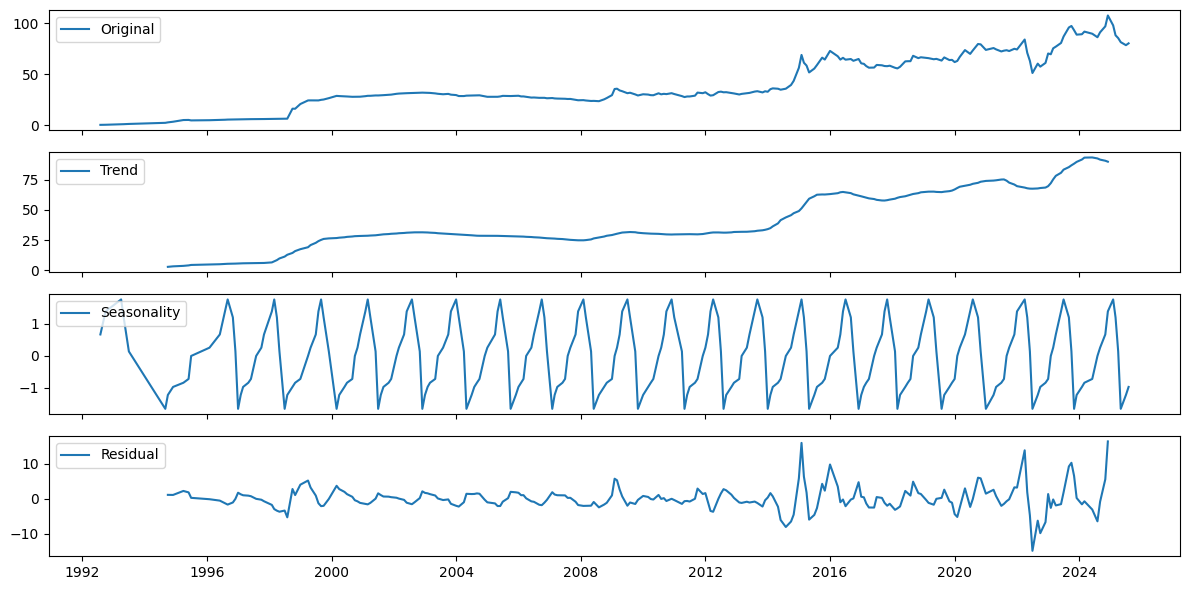

In [276]:
data_decomp = data.copy()
data_decomp['date'] = pd.to_datetime(data_decomp['date'])
data_decomp = data_decomp.sort_values('date')
data_decomp = data_decomp.set_index('date')

# secompose with period=12 (monthly seasonality)
decomposition = seasonal_decompose(rub_series, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(decomposition.resid, label='Residual')
axes[3].legend(loc='upper left')
plt.tight_layout()
plt.show()

#### With Seasonal-Trend decomposition using LOESS (STL) decomposition

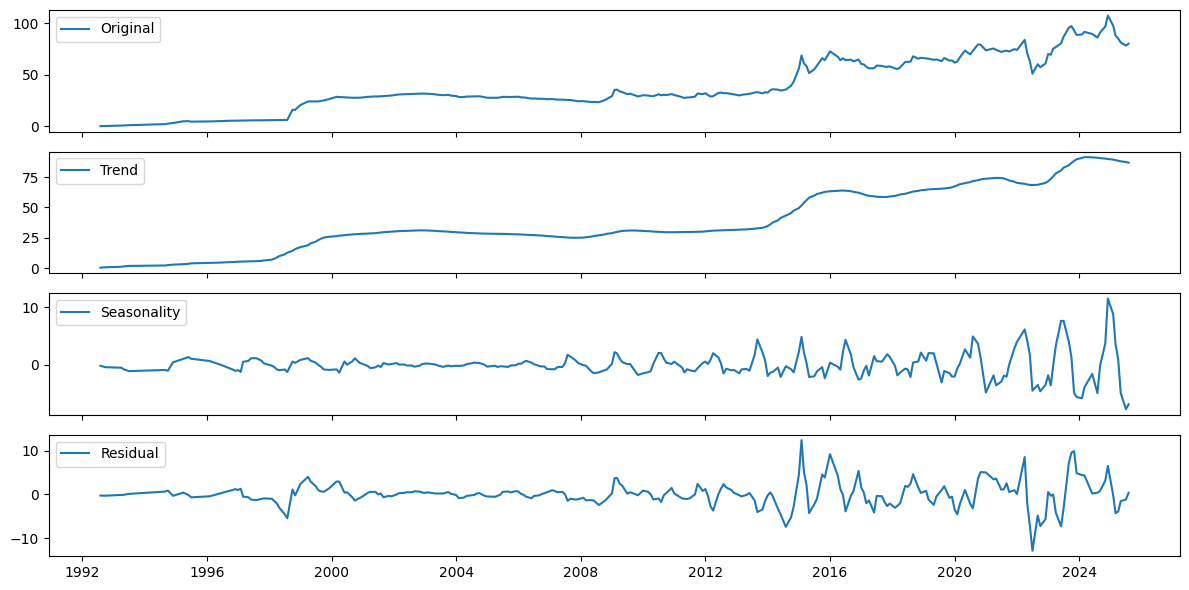

In [226]:
stl = STL(rub_series, period=12) 
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
resid = result.resid


fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
axes[0].plot(rub_series, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(resid, label='Residual')
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

STL offers superior performance for long-term, real-world financial data like exchange rates, especially when structural breaks or non-stationary behavior is present.

In [227]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -0.8768242099196052
p-value: 0.7955087074195493
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}


Since the ADF statistic is higher than all critical values, and the p-value is well above 0.05, we fail to reject the null hypothesis of a unit root. This indicates that the RUB time series is non-stationary.
To proceed with time series modeling, let's apply first-order differencing to induce stationarity.

In [228]:
data.loc[:, 'RUB_diff1'] = data['RUB'].diff()  # First difference (today - yesterday)
data.loc[:, 'RUB_diff12'] = data['RUB'].diff(12)  # Seasonal difference (this month - same month last year)

rub_diff1 = data['RUB_diff1'].dropna()
result = adfuller(rub_diff1)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -13.144559968966986
p-value: 1.406932011558584e-24


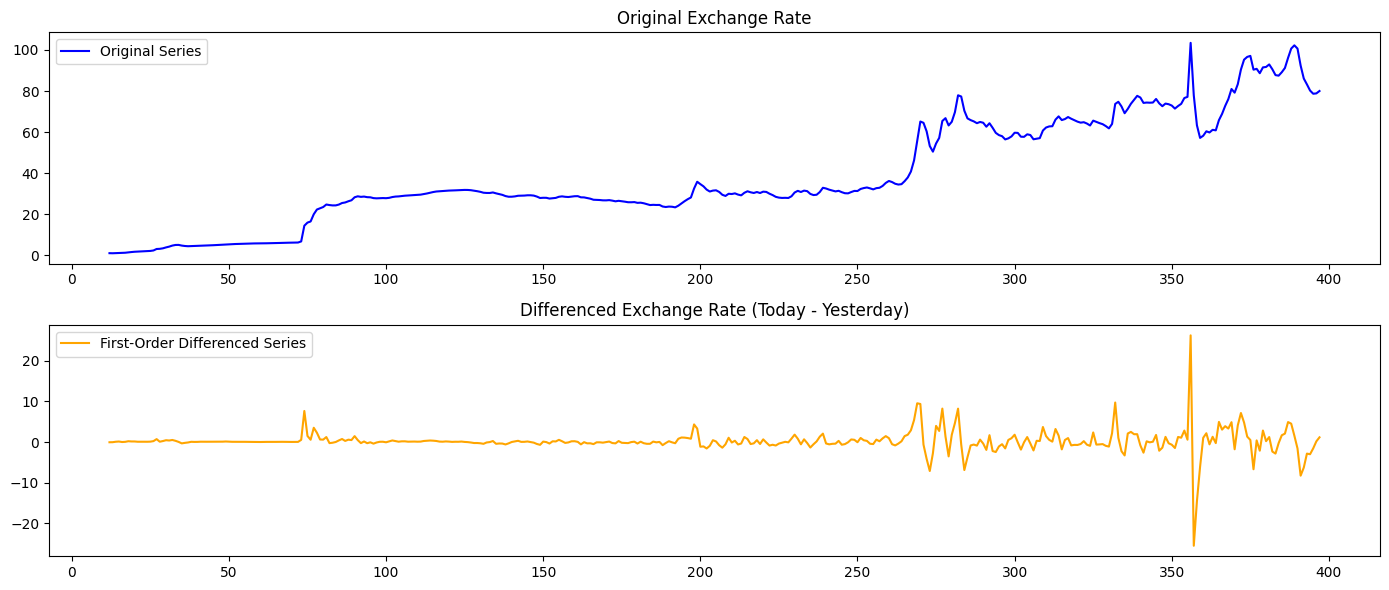

In [197]:
# First-order differencing
data['RUB_diff1'] = data['RUB'].diff()
data = data.dropna()

# Plotting both
plt.figure(figsize=(14, 6))

# Original
plt.subplot(2, 1, 1)
plt.plot(data['RUB'], label='Original Series', color='blue')
plt.title('Original Exchange Rate')
plt.legend()

# Differenced
plt.subplot(2, 1, 2)
plt.plot(data['RUB_diff1'], label='First-Order Differenced Series', color='orange')
plt.title('Differenced Exchange Rate (Today - Yesterday)')
plt.legend()

plt.tight_layout()
plt.show()

### 2. ARIMA

#### 2.0 CV and Folds

In [293]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv")

In [294]:
data_work = data.copy()

In [295]:
# Define CV blocks
cv_blocks = [
    (1992, 1999, 2000),
    (2000, 2007, 2008),
    (2008, 2015, 2016),
    (2016, 2023, 2024),
]

# Create train/test masks for each fold
for fold, (train_start, train_end, test_year) in enumerate(cv_blocks, start=1):
    data_work[f"train{fold}"] = (data_work["year"] >= train_start) & (data_work["year"] <= train_end)
    data_work[f"test{fold}"]  = data_work["year"] == test_year

data_work["holdout"] = data_work["year"] == 2025

In [296]:
data_work

,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,...,Inflation,train1,test1,train2,test2,train3,test3,train4,test4,holdout
0,1992-07-31,141.556000,1992.0,3.0,7.0,16.000000,4.000000,0.0,2.928888,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
1,1992-08-31,168.162500,1992.0,3.0,8.0,16.500000,4.000000,0.0,3.274988,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
2,1992-09-30,220.488889,1992.0,3.0,9.0,15.333333,3.888889,0.0,2.546404,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
3,1992-10-31,353.777778,1992.0,4.0,10.0,16.666667,4.111111,0.0,5.348118,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
4,1992-11-30,426.250000,1992.0,4.0,11.0,15.500000,4.000000,0.0,1.491099,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2025-04-30,83.243645,2025.0,2.0,4.0,15.318182,2.954545,0.0,-0.213785,post,...,8.140000,False,False,False,False,False,False,False,False,True
394,2025-05-31,80.237650,2025.0,2.0,5.0,17.150000,3.000000,0.0,-0.178412,post,...,8.140000,False,False,False,False,False,False,False,False,True
395,2025-06-30,78.677635,2025.0,2.0,6.0,15.400000,2.850000,0.0,-0.004909,post,...,8.140000,False,False,False,False,False,False,False,False,True
396,2025-07-31,78.850139,2025.0,3.0,7.0,16.000000,3.000000,0.0,0.101659,post,...,8.140000,False,False,False,False,False,False,False,False,True


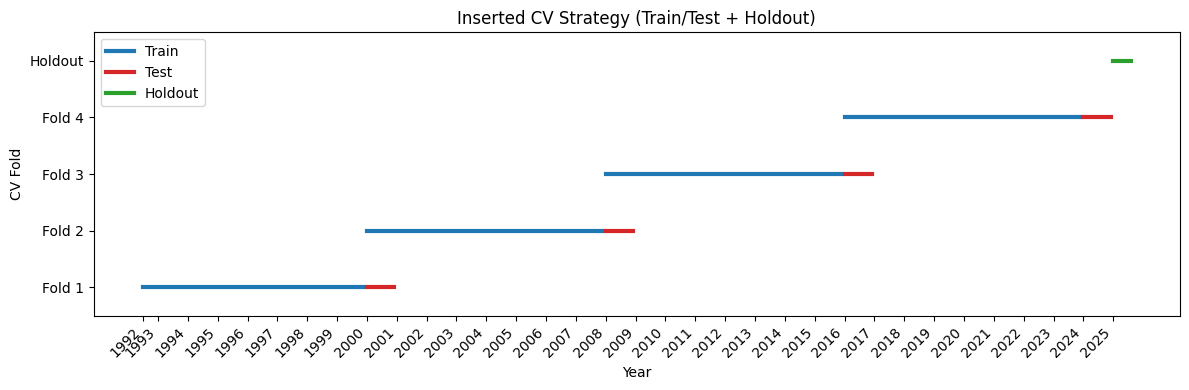

In [284]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot CV folds
for fold in range(1, 5):
    train_mask = data_work[f"train{fold}"]
    test_mask  = data_work[f"test{fold}"]

    # Train
    ax.plot(
        data_work.loc[train_mask, "date"], 
        [fold] * train_mask.sum(), 
        color='tab:blue', 
        label="Train" if fold == 1 else "", 
        linewidth=3  
    )

    # Test
    ax.plot(
        data_work.loc[test_mask, "date"], 
        [fold] * test_mask.sum(), 
        color='tab:red', 
        label="Test" if fold == 1 else "", 
        linewidth=3  
    )

# --- Holdout (year 2025) ---
holdout_mask = data_work["holdout"]
ax.plot(
    data_work.loc[holdout_mask, "date"], 
    [5] * holdout_mask.sum(), 
    color='tab:green', 
    label="Holdout", 
    linewidth=3
)

# --- Y axis labels ---
yticks = list(range(1, 6))
yticklabels = [f"Fold {i}" for i in range(1, 5)] + ["Holdout"]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylim(0.5, 5.5)
ax.set_ylabel("CV Fold")

# --- X axis: yearly ticks ---
years = pd.to_datetime(data_work["date"]).dt.year.unique()
years = sorted(years)
year_to_first_date = {
    year: data_work.loc[pd.to_datetime(data_work["date"]).dt.year == year, "date"].iloc[0]
    for year in years
}
x_tick_positions = [year_to_first_date[year] for year in years]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels([str(year) for year in years], rotation=45, ha='right')

# Final formatting
ax.set_xlabel("Year")
ax.set_title("Inserted CV Strategy (Train/Test + Holdout)")
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

#### 2.1 Auto Arima with no Intercept

In [ ]:
#Auto_arima with no intercept (trend='n')

model_1 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    trend='n'            
)


best_order = model_1.order  #
print("Best ARIMA order:", best_order)

mse_2 = []

for i in range(1, 5):
    
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    model_cv = ARIMA(endog=y_train, order=best_order, trend='n').fit()  # Avoid overwriting model_1
    phat = model_cv.forecast(steps=len(y_test))
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [261]:
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  398
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -953.918
Date:                Wed, 17 Sep 2025   AIC                           1917.836
Time:                        17:45:40   BIC                           1937.756
Sample:                             0   HQIC                          1925.727
                                - 398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8660      0.028     31.111      0.000       0.811       0.921
ar.L2         -0.9587      0.019    -51.663      0.000      -0.995      -0.922
ma.L1         -0.7949      0.036    -22.143      0.0

#### 2.2 Auto Arima with Intercept (t)

In [264]:
# Auto_arima with intercept (trend='t')

model_2 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    trend='t'            
)

best_order = model_2.order
print("Best ARIMA order:", best_order)

mse_2 = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Use trend='t' to match the auto_arima model
    model_cv = ARIMA(endog=y_train, order=best_order, trend='t').fit()
    phat = model_cv.forecast(steps=len(y_test))
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.619, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1927.283, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.775, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.619, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1929.128, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.734, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1929.512, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1926.775, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.404 seconds
Best ARIMA order: (0, 1, 1)
CV RMSE (Auto ARIMA): 6.1064849218541495
     lb_stat  lb_pvalue
10  1.533744   0.998826


In [266]:
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  398
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -960.387
Date:                Wed, 17 Sep 2025   AIC                           1926.775
Time:                        17:48:10   BIC                           1938.727
Sample:                             0   HQIC                          1931.509
                                - 398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0008      0.001      1.480      0.139      -0.000       0.002
ma.L1          0.1569      0.013     12.021      0.000       0.131       0.182
sigma2         7.3911      0.132     56.023      0.0

#### 2.3 ARIMAX without Intercept (Shocks + Oil Price & Inflation)

In [297]:
# Make sure date column is datetime and set as index
data_work["date"] = pd.to_datetime(data_work["date"])
data_work = data_work.set_index("date").asfreq("M")

# Define shocks by year-month ranges
shock_windows = {
    "shock_1998_default": ((1998, 8), (1998, 11)),
    "shock_2008_gfc": ((2008, 9), (2008, 12)),
    "shock_2014_crimea": ((2014, 3), (2014, 6)),
    "shock_2020_covid": ((2020, 3), (2020, 6)),
    "shock_2022_invasion": ((2022, 2), (2022, 5)),
}

# Add dummy variables for shocks
for shock_name, ((start_y, start_m), (end_y, end_m)) in shock_windows.items():
    mask = (
        ((data_work.index.year > start_y) | ((data_work.index.year == start_y) & (data_work.index.month >= start_m)))
        & ((data_work.index.year < end_y) | ((data_work.index.year == end_y) & (data_work.index.month <= end_m)))
    )
    data_work[shock_name] = mask.astype(int)

# Quick check
print(data_work[[c for c in data_work.columns if "shock" in c]].sum())

shock_1998_default     4
shock_2008_gfc         4
shock_2014_crimea      4
shock_2020_covid       4
shock_2022_invasion    4
dtype: int64


In [312]:
data.columns

Index(['date', 'currency_rate', 'year', 'quarter', 'month', 'day', 'dow',
       'weekend', 'currency_rate_change', 'denomination', 'RUB',
       'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment',
       'Inflation'],
      dtype='object')

In [318]:
exog_all = data_work[[
    "Brent_price", "Inflation",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]


model_3 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'            # no constant
)

best_order = model_3.order
print("Best ARIMAX order:", best_order)

mse_cv = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test" + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()
    phat = model_cv.forecast(steps=len(y_test), exog=exog_test)

    err_sq = (y_test.values - phat.values) ** 2
    mse_cv.append(np.mean(err_sq))

rmse_cv_arimax = float(np.sqrt(np.mean(mse_cv)))
print("Cross-validated RMSE (ARIMAX):", rmse_cv_arimax)

print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

model_3 = ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=best_order,
    trend='n'
).fit()

print(model_3.summary()) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cross-validated RMSE (ARIMAX): 4.953292300880851
     lb_stat  lb_pvalue
10  0.884669   0.999902
                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -947.265
Date:                Wed, 17 Sep 2025   AIC                           1918.530
Time:                        18:22:57   BIC                           1966.337
Sample:                    07-31-1992   HQIC                          1937.468
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Brent_price            -0.0813      0.022     -3.749      0.000      -0.124      -0.039
Inflati

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 2.4 ARIMAX without Intercept (Shocks + Oil Price, FD Investemnt and GDP)

In [319]:
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]


model_4 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'            # no constant
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

mse_cv = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test" + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()
    phat = model_cv.forecast(steps=len(y_test), exog=exog_test)

    err_sq = (y_test.values - phat.values) ** 2
    mse_cv.append(np.mean(err_sq))

rmse_cv_arimax = float(np.sqrt(np.mean(mse_cv)))
print("Cross-validated RMSE (ARIMAX):", rmse_cv_arimax)

print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

model_4 = ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=best_order,
    trend='n'
).fit()

print(model_4.summary()) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

Cross-validated RMSE (ARIMAX): 3.875798415686922
    lb_stat  lb_pvalue
10  1.11913   0.999712
                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -950.919
Date:                Wed, 17 Sep 2025   AIC                           1927.838
Time:                        18:23:05   BIC                           1979.629
Sample:                    07-31-1992   HQIC                          1948.354
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Brent_price            -0.0789   4.44e-07  -1.78e+05      0.000      -0.079      -0.079
FD_invest

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 2.5 ARIMAX without Intercept (Shocks + Oil Price, FD Investemnt and GDP) Plot

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


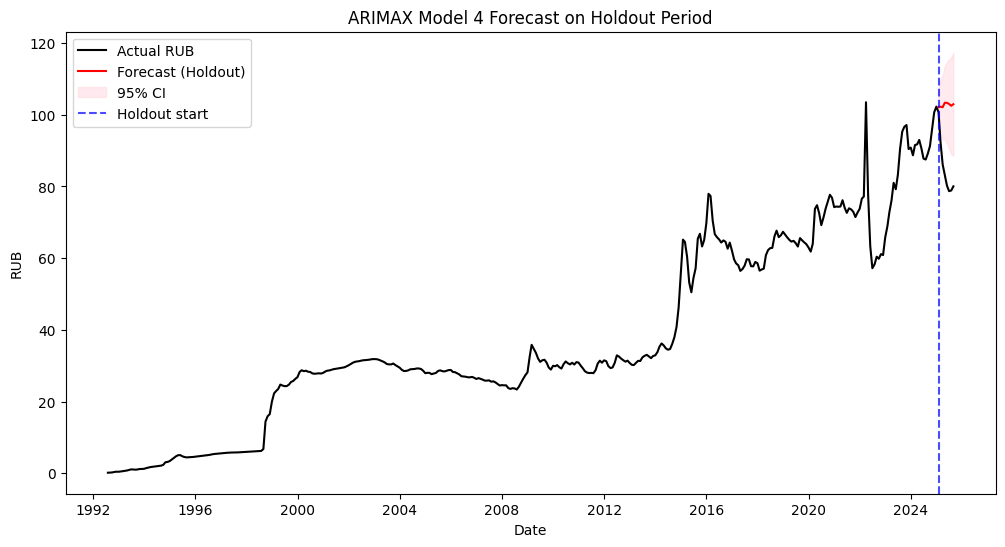

In [ ]:
y = data_work["RUB"]
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work["holdout"]]
exog_train = exog_all[~data_work["holdout"]]

y_holdout = y[data_work["holdout"]]
exog_holdout = exog_all[data_work["holdout"]]

# 2. Refit final ARIMAX on full training data
model_4 = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n").fit()

# 3. Forecast for holdout
forecast_res = model_4.get_forecast(steps=len(y_holdout), exog=exog_holdout)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# 4. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="Forecast (Holdout)", color="red")

# Confidence intervals
plt.fill_between(
    y_holdout.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    color="pink", alpha=0.3, label="95% CI"
)

plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX Model 4 Forecast on Holdout Period")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

### 3. GARCH

In [ ]:
data_work["log_rub"] = np.log(data_work["RUB"])
data_work["ret_rub"] = data_work["log_rub"].diff().dropna()

In [ ]:
!pip install arch 


python(94259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
11873.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached arch-7.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (13 kB)
Using cached arch-7.2.0-cp311-cp311-macosx_11_0_arm64.whl (925 kB)


In [361]:
from arch import arch_model

In [362]:
# Drop NaN after differencing
returns = data_work["ret_rub"].dropna()

# GARCH(1,1) with normal distribution
garch_model = arch_model(returns, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_rub   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                665.663
Distribution:                  Normal   AIC:                          -1323.33
Method:            Maximum Likelihood   BIC:                          -1307.39
                                        No. Observations:                  397
Date:                Wed, Sep 17 2025   Df Residuals:                      396
Time:                        20:48:37   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.0168e-03  3.115e-03     -1.611      0.

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004705. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Forecasted variances: [0.00130918 0.00187604 0.00235315 0.0027547  0.00309267 0.00337713
 0.00361654 0.00381804 0.00398763 0.00413037 0.0042505  0.00435162]


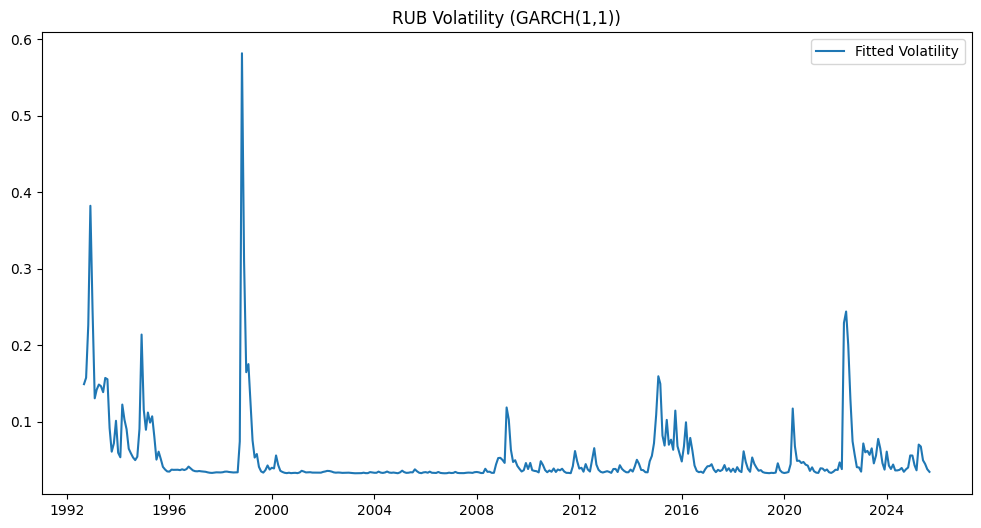

In [363]:
# Forecast next 12 months volatility
garch_forecast = garch_res.forecast(horizon=12)

# Extract conditional variance forecast
vol_forecast = garch_forecast.variance.values[-1, :]
print("Forecasted variances:", vol_forecast)

# Plot conditional volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(garch_res.conditional_volatility, label="Fitted Volatility")
plt.title("RUB Volatility (GARCH(1,1))")
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -621.195
Distribution:                  Normal   AIC:                           1250.39
Method:            Maximum Likelihood   BIC:                           1266.34
                                        No. Observations:                  398
Date:                Wed, Sep 17 2025   Df Residuals:                      397
Time:                        20:50:32   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1066  3.469e-02      3.074  2.113e-03 [3.864e-0

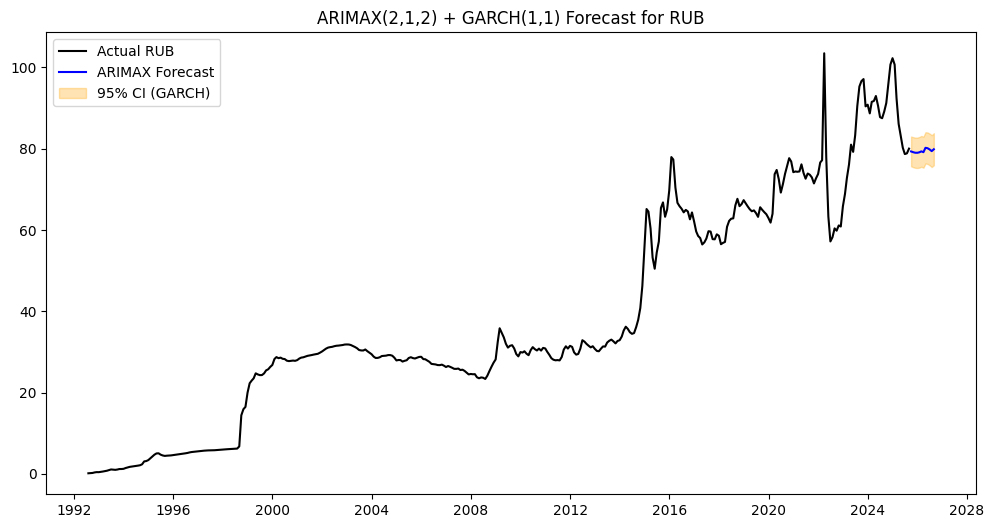

In [364]:
# --- 1. Fit ARIMAX(2,1,2) with exogenous variables ---
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

arimax_model = sm.tsa.ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=(2,1,2),
    trend='n'
)
arimax_res = arimax_model.fit()

# --- 2. Extract residuals from ARIMAX ---
residuals = arimax_res.resid

# --- 3. Fit GARCH(1,1) on residuals ---
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

print(garch_res.summary())

# --- 4. Forecast volatility ---
garch_forecast = garch_res.forecast(horizon=12)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # standard deviation

# --- 5. Forecast mean RUB (from ARIMAX) ---
steps = 12
exog_future = exog_all.tail(steps)  # replace with your future exog
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_future)
mean_forecast = arimax_forecast.predicted_mean

# --- 6. Combine mean + volatility bands ---
upper = mean_forecast + 1.96 * vol_forecast
lower = mean_forecast - 1.96 * vol_forecast

plt.figure(figsize=(12,6))
plt.plot(data_work.index, data_work["RUB"], label="Actual RUB", color="black")
plt.plot(mean_forecast.index, mean_forecast, label="ARIMAX Forecast", color="blue")
plt.fill_between(mean_forecast.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.legend()
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast for RUB")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


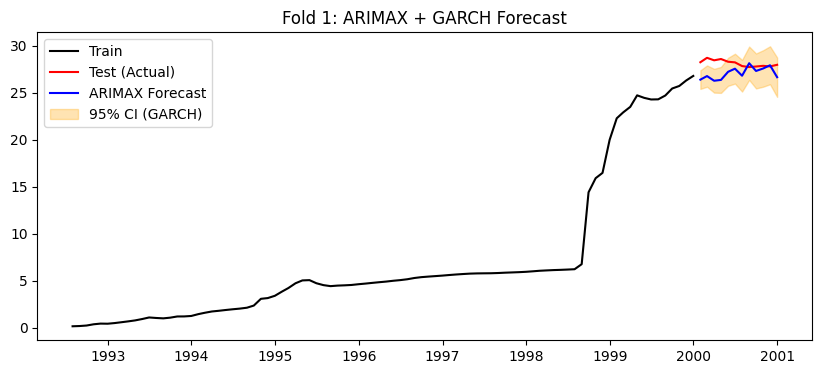

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


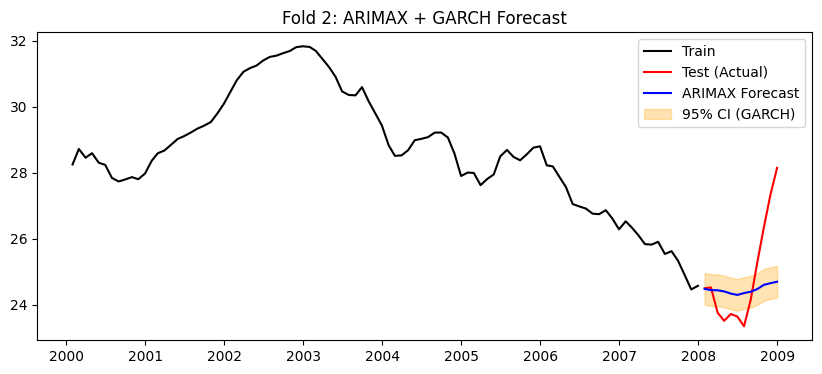

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


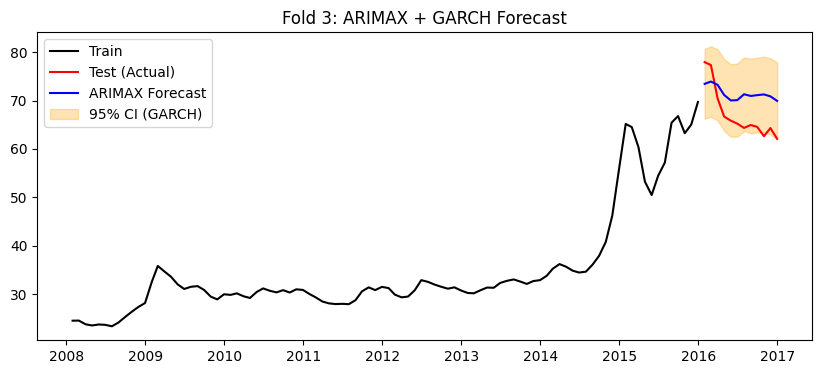

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


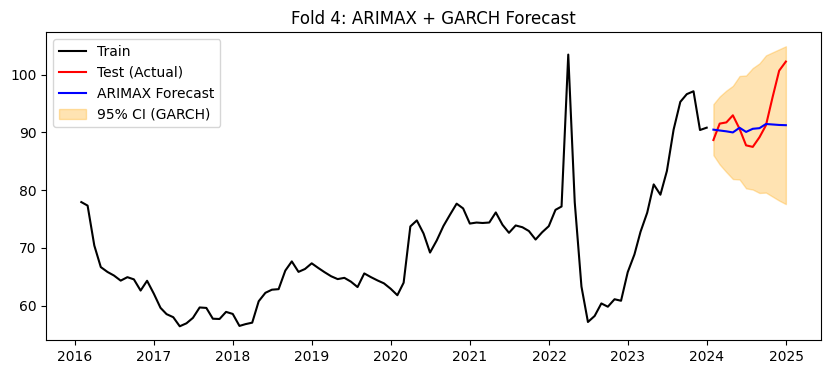

Cross-validated RMSE (ARIMAX+GARCH): 3.338107231557277


In [365]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. Setup exogenous
# ======================
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

# ======================
# 2. Auto-ARIMAX to get best order
# ======================
model_4 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

# ======================
# 3. Cross-validation with ARIMAX + GARCH
# ======================
rmse_folds = []

for i in range(1, 5):
    # ---- Train/Test split
    train_mask = data_work[f"train{i}"]
    test_mask  = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    # ---- Step 1: Fit ARIMAX
    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()

    # ---- Step 2: Get residuals & fit GARCH
    residuals = model_cv.resid
    garch = arch_model(residuals, vol="GARCH", p=1, q=1)
    garch_fit = garch.fit(disp="off")

    # ---- Step 3: Forecast ARIMAX mean
    phat_mean = model_cv.forecast(steps=len(y_test), exog=exog_test)

    # ---- Step 4: Forecast GARCH volatility (optional, CI bands)
    garch_forecast = garch_fit.forecast(horizon=len(y_test))
    vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

    # ---- Step 5: Evaluate RMSE (using mean only)
    err_sq = (y_test.values - phat_mean.values) ** 2
    rmse = np.sqrt(np.mean(err_sq))
    rmse_folds.append(rmse)

    # ---- Optional Plot per fold
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train, label="Train", color="black")
    plt.plot(y_test.index, y_test, label="Test (Actual)", color="red")
    plt.plot(y_test.index, phat_mean, label="ARIMAX Forecast", color="blue")
    plt.fill_between(y_test.index, phat_mean - 1.96*vol_forecast,
                     phat_mean + 1.96*vol_forecast, color="orange", alpha=0.3,
                     label="95% CI (GARCH)")
    plt.title(f"Fold {i}: ARIMAX + GARCH Forecast")
    plt.legend()
    plt.show()

# ======================
# 4. Final CV RMSE
# ======================
rmse_cv_arimax_garch = float(np.mean(rmse_folds))
print("Cross-validated RMSE (ARIMAX+GARCH):", rmse_cv_arimax_garch)

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


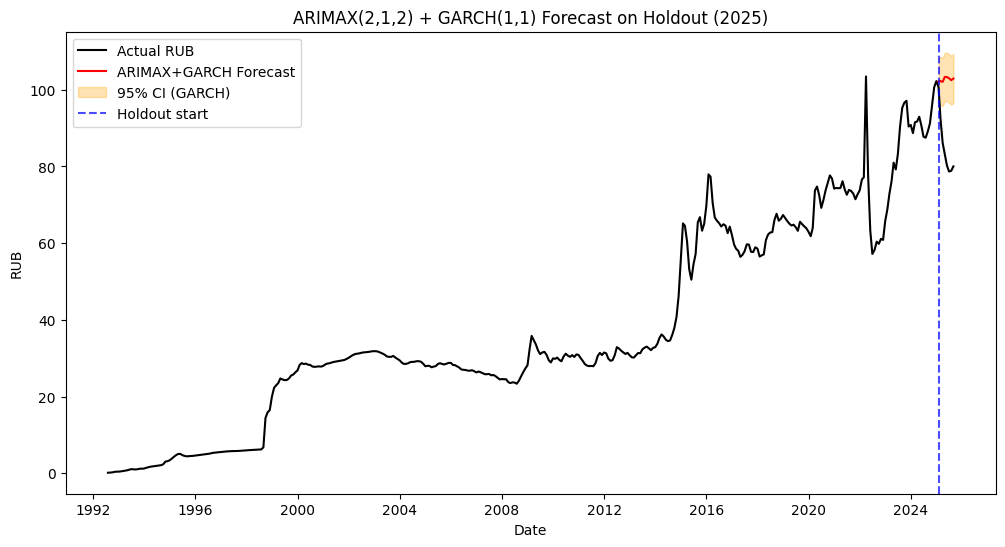

In [366]:
from arch import arch_model

# 1. Endogenous and exogenous split
y = data_work["RUB"]
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work["holdout"]]
exog_train = exog_all[~data_work["holdout"]]

y_holdout = y[data_work["holdout"]]
exog_holdout = exog_all[data_work["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2025)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()